# DRAFT Pick Equity
Analyzing the value of picks in DRAFT Best Ball drafts as well as over- and under-performance patterns.

## Libraries

In [21]:
import logging
import sys

import math
import numpy as np
import pandas as pd

from pandas_gbq import read_gbq
from google.oauth2 import service_account

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from pygam import (
    LinearGAM,
    s,
    te
)

## Setup

In [2]:
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [3]:
PROJECT_ID = 'ad-fantasy-football'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-loader.json'
BQ_CREDENTIALS = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_PATH
)

In [4]:
PARAMS = {
    'participants': '12',
    'min_date': '2018-07-01',
    'max_date': '2018-09-06'
}

In [5]:
SQL_BASE = \
"""
SELECT
  draft_id,
  team_id,
  round_number,
  pick_number,
  MAX(draft_tm) AS draft_time,
  DATE_DIFF('{max_date}', DATE(MAX(draft_tm)), DAY) AS days_to_season,
  MAX(player_id) AS player_id,
  MAX(first_name) AS first_name,
  MAX(last_name) AS last_name,
  MAX(position) AS position,
  MAX(team) AS team,
  MAX(total_points) AS total_points,
  MAX(league_rank) AS league_rank,
  SUM(fantasy_points) AS player_total_points,
  SUM(CASE WHEN player_counts THEN fantasy_points ELSE 0 END) AS player_contributed_points
FROM
  `ad-fantasy-football.playdraft_2018.v_full`
WHERE
  complete_true_false = true
    AND DATE(draft_tm) >= '{min_date}'
    AND DATE(draft_tm) <= '{max_date}'
    AND participants = {participants}
    AND draft_timer = 'Fast'
GROUP BY 1, 2, 3, 4
"""

In [6]:
sql_base = SQL_BASE.format(**PARAMS)

df_base = pd.read_gbq(
    query=sql_base,
    project_id=PROJECT_ID,
    dialect='standard',
    credentials=BQ_CREDENTIALS
)

Requesting query... 
Query running...
Job ID: 812a0802-a833-4826-b8ab-98fa9885c452
Query done.
Cache hit.

Got 3873312 rows.

Total time taken 863.2 s.
Finished at 2019-08-18 16:24:39.


In [7]:
df_base.head(30)

,draft_id,team_id,round_number,pick_number,draft_time,days_to_season,player_id,first_name,last_name,position,team,total_points,league_rank,player_total_points,player_contributed_points
0,3b85ca8a-673d-4011-92fb-dce39499b5b8,75cd693f-8e86-44fa-afd0-f9c0ffc000f9,11,122,2018-09-03 16:51:30.817899+00:00,3,977,Latavius,Murray,RB,MIN,1568.34,10,119.10,92.20
1,0618e540-263b-4f45-9593-ef1658be06ea,3c84f6ad-9914-4e1c-86e3-944dbfc06651,7,84,2018-08-14 15:09:06.550569+00:00,23,284,Drew,Brees,QB,NO,1583.72,11,309.48,212.82
2,124c8228-f035-4748-80fe-d7a7664c245b,7a25a7a0-f6ca-4377-9c49-5c2c1bf1dbb6,18,210,2018-08-23 15:22:28.397539+00:00,14,21432,Dede,Westbrook,WR,JAC,1832.88,1,146.10,82.60
3,15a05ebd-c66a-44ff-ab91-e6b1b60b8548,1cce90b8-6eed-48e1-b601-a47cade84180,15,179,2018-08-14 09:16:36.737267+00:00,23,64,Case,Keenum,QB,DEN,1592.48,8,216.42,37.66
4,22672c18-05c1-4a3a-93c2-3451adfc00ea,59a0ade3-5bbb-43d9-8e38-36d3a0b150f1,16,187,2018-08-26 18:42:24.490347+00:00,11,19190,Josh,Doctson,WR,WAS,1699.80,10,82.90,43.80
5,29a7b6a0-8ba8-4dc3-a844-a9f7f6481873,84b6b1f0-7fa1-47b1-bbd3-79905f931aac,14,160,2018-07-05 22:30:18.920049+00:00,63,21584,Mitchell,Trubisky,QB,CHI,1830.08,2,264.90,153.78
6,2a4ce31f-502d-42a2-b36f-394a56be288f,50d7712e-2d96-4442-86ce-9885b36297a6,3,28,2018-07-27 12:49:23.789725+00:00,41,861,LeSean,McCoy,RB,BUF,1428.26,11,98.80,21.00
7,2bae49e2-f401-40dc-bb24-5690fa733681,48470f0c-2001-454f-b4e9-dc0d864f4241,8,85,2018-08-15 19:14:27.657003+00:00,22,833,Trey,Burton,TE,CHI,1647.70,6,114.30,55.20
8,33250463-2a93-4fb3-a8e8-eca82eddde63,81436441-e204-4c92-b23c-e5584d66ea25,8,90,2018-07-21 23:10:03.322796+00:00,47,284,Drew,Brees,QB,NO,1893.32,1,309.48,271.18
9,3b0437e5-a696-49d3-a230-24de66687dab,a61cc6be-d69f-4072-8d19-4ae5f4ab7e84,10,109,2018-08-05 11:38:01.826028+00:00,32,22932,Nick,Chubb,RB,CLE,1775.72,3,181.50,145.20


## Data Preparation

In [8]:
POSITIONS = ['qb', 'rb', 'wr', 'te']

In [9]:
df_base['win_flag'] = df_base['league_rank'] == 1

## Analysis

In [10]:
sns.set(rc={'figure.figsize':(16,9)})

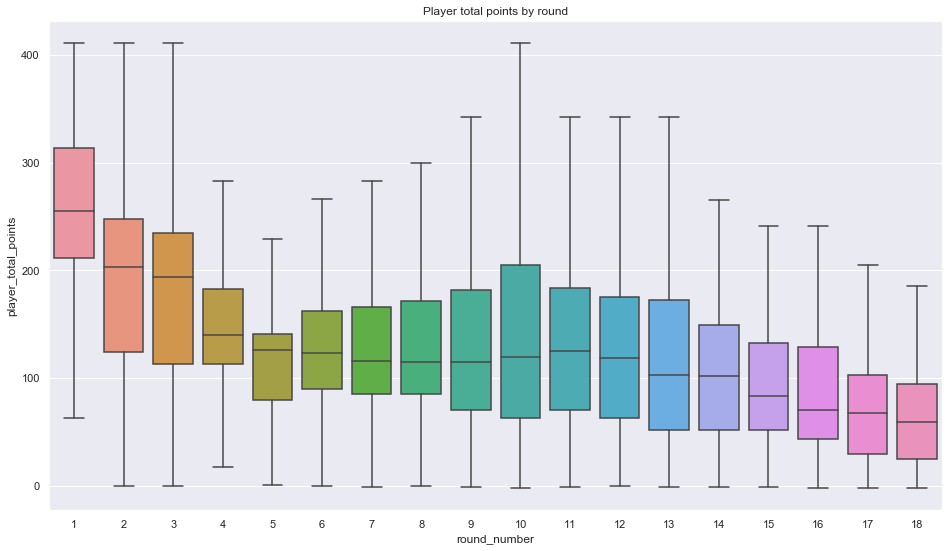

In [11]:
sns.boxplot(
    data=df_base,
    x='round_number',
    y='player_total_points',
    fliersize=0
)

plt.title('Player total points by round')
plt.show()

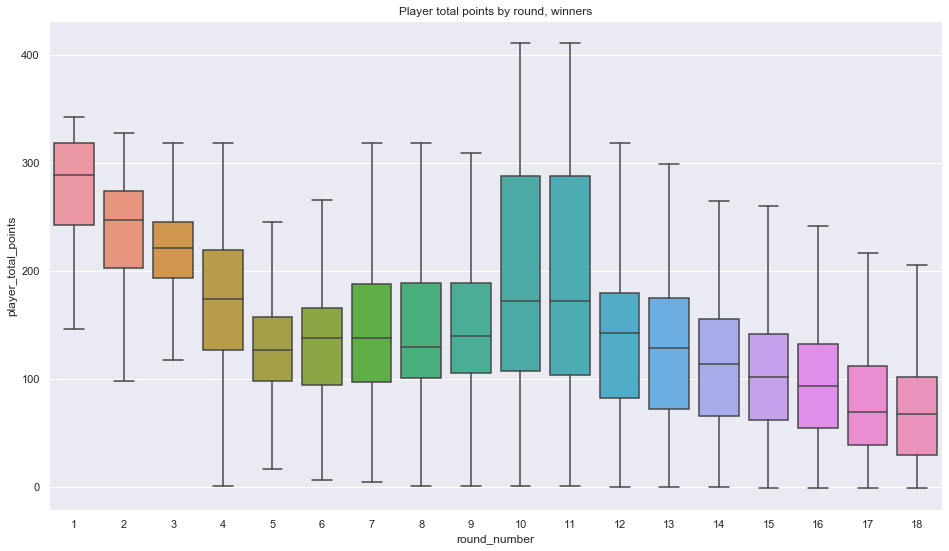

In [12]:
sns.boxplot(
    data=df_base[df_base['win_flag'] == True],
    x='round_number',
    y='player_total_points',
    fliersize=0
)

plt.title('Player total points by round, winners')
plt.show()

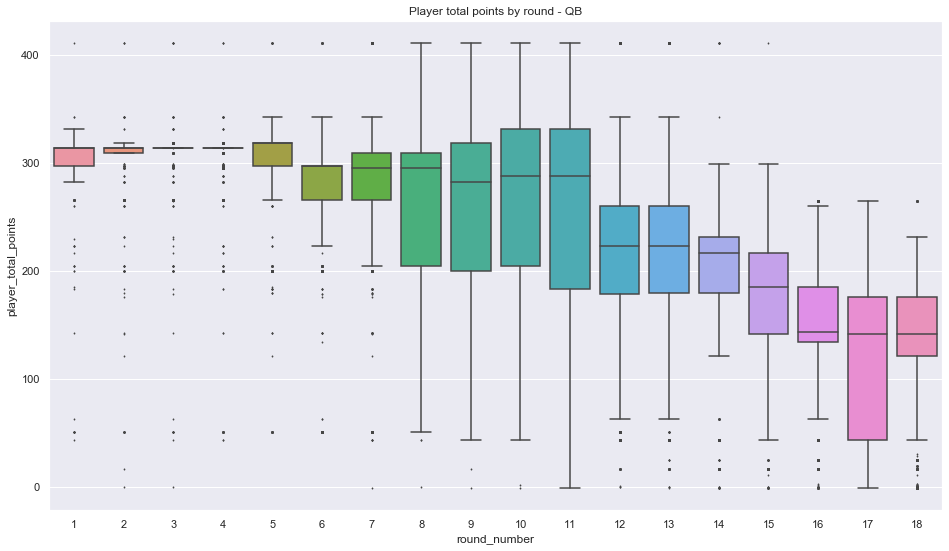

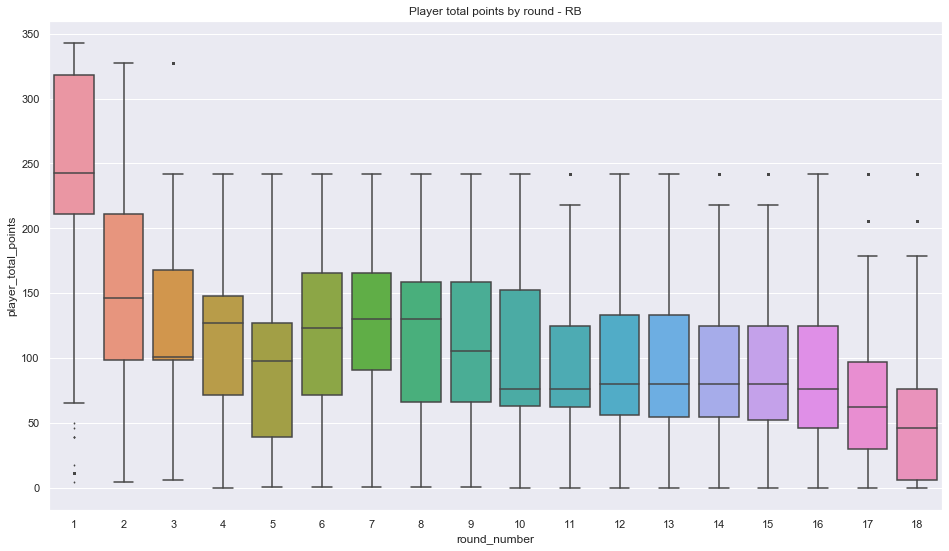

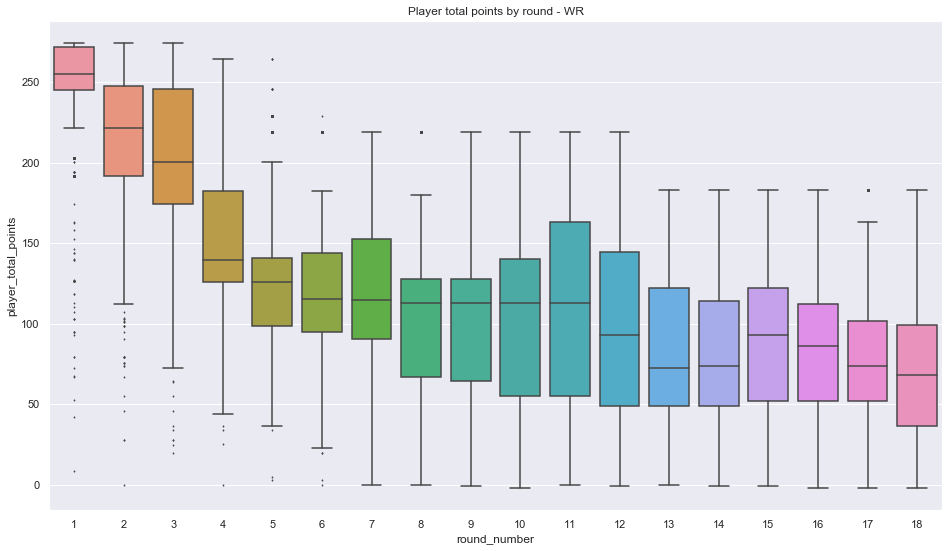

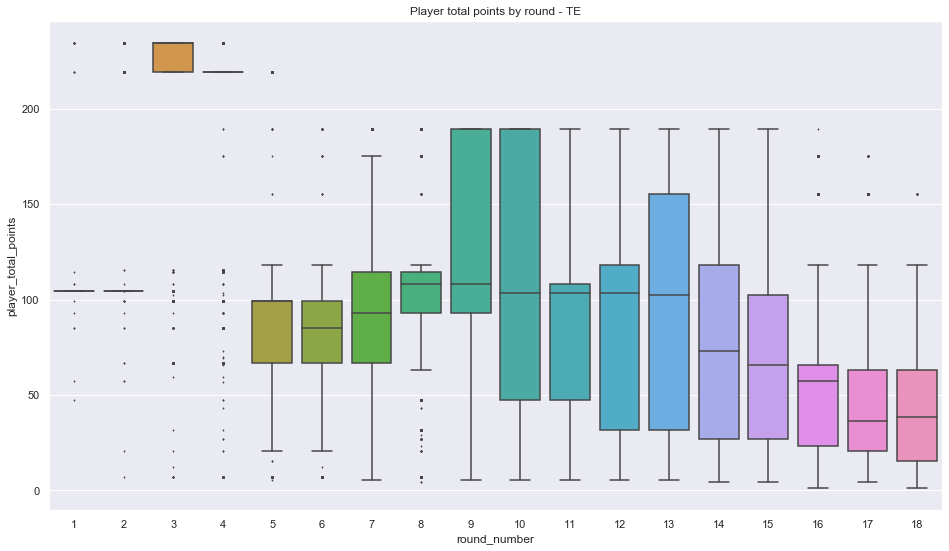

In [13]:
for position in POSITIONS:
    _data = df_base[df_base['position'] == position.upper()]
    
    sns.boxplot(
        data=_data,
        x='round_number',
        y='player_total_points',
        fliersize=1
    )
    
    plt.title('Player total points by round - {0}'.format(position.upper()))
    plt.show()

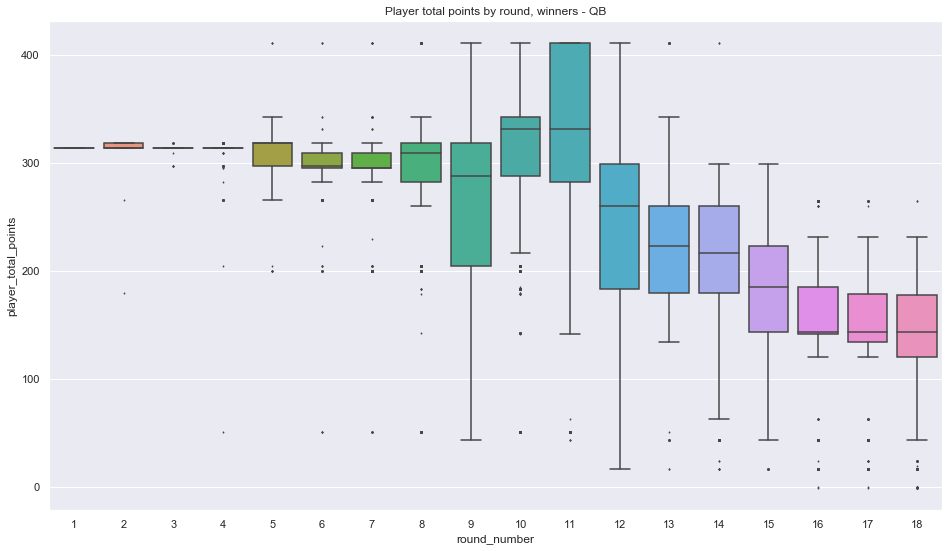

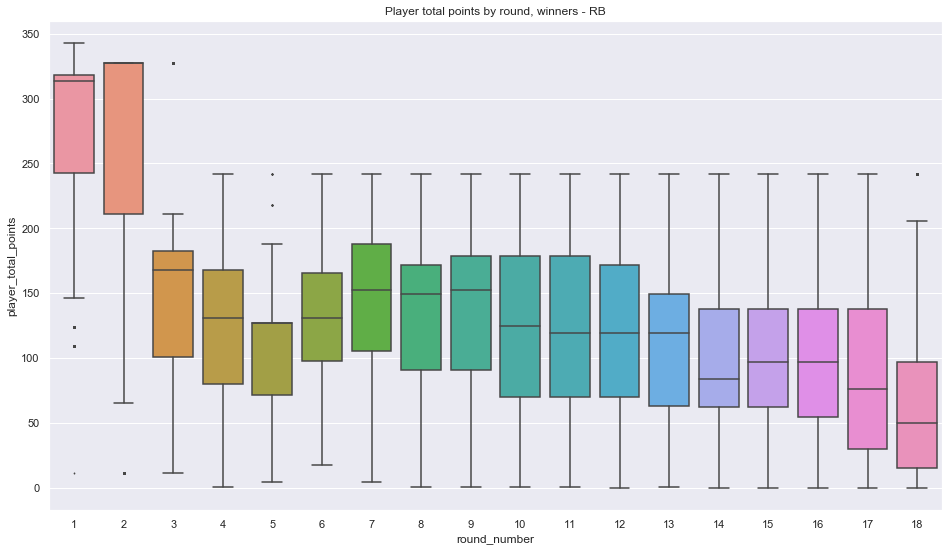

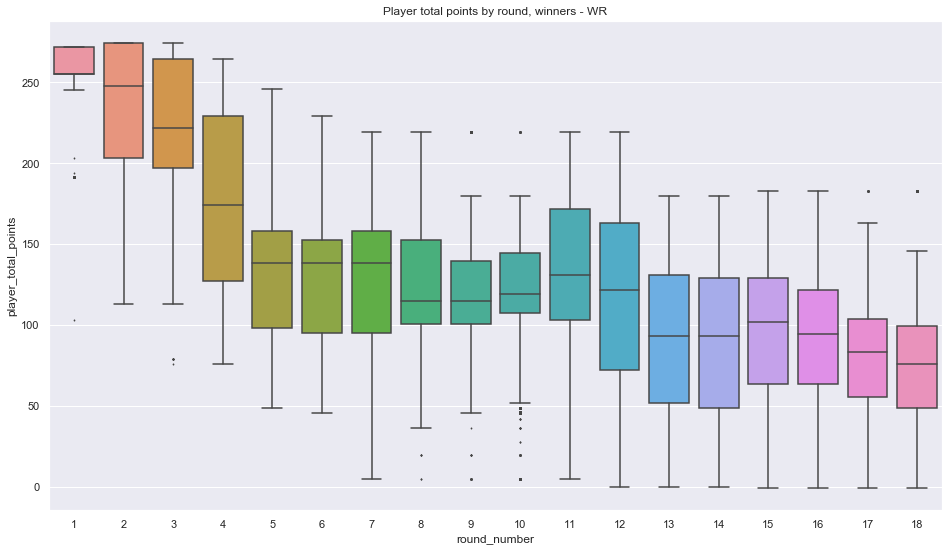

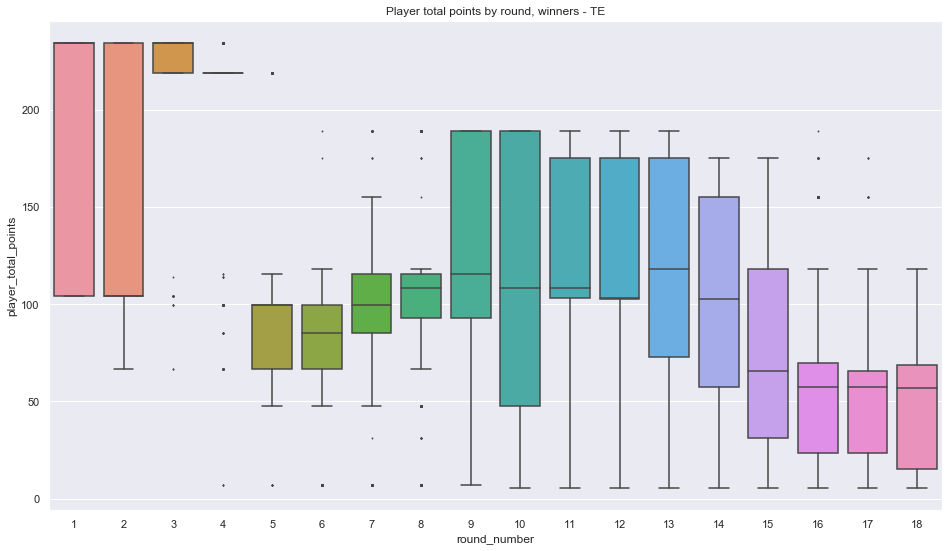

In [14]:
for position in POSITIONS:
    _data = df_base[
        (df_base['position'] == position.upper()) & 
        (df_base['win_flag'] == 1)
    ]
    
    sns.boxplot(
        data=_data,
        x='round_number',
        y='player_total_points',
        fliersize=1
    )
    
    plt.title('Player total points by round, winners - {0}'.format(position.upper()))
    plt.show()

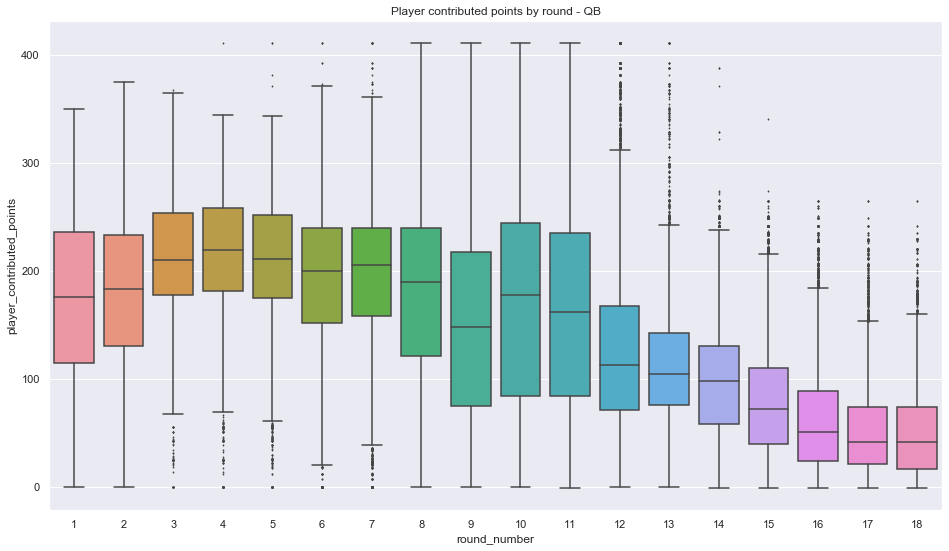

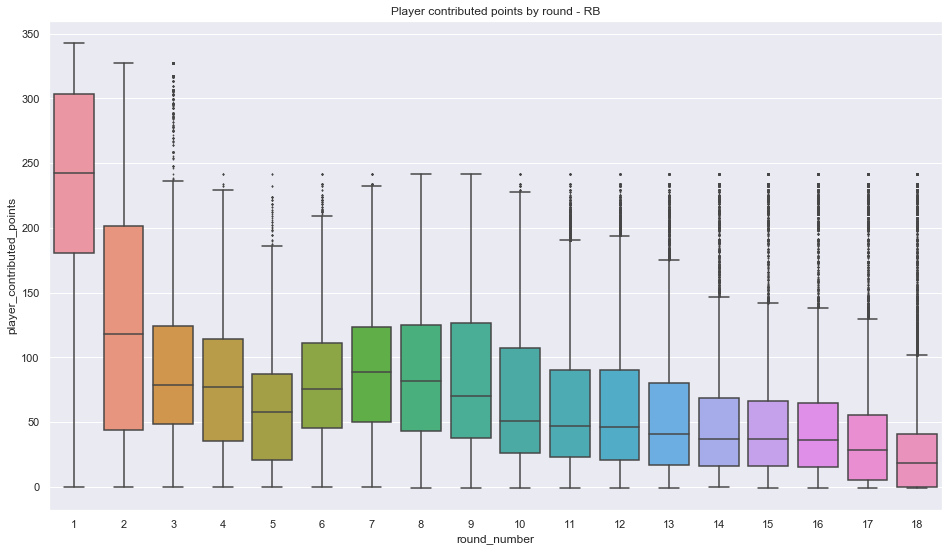

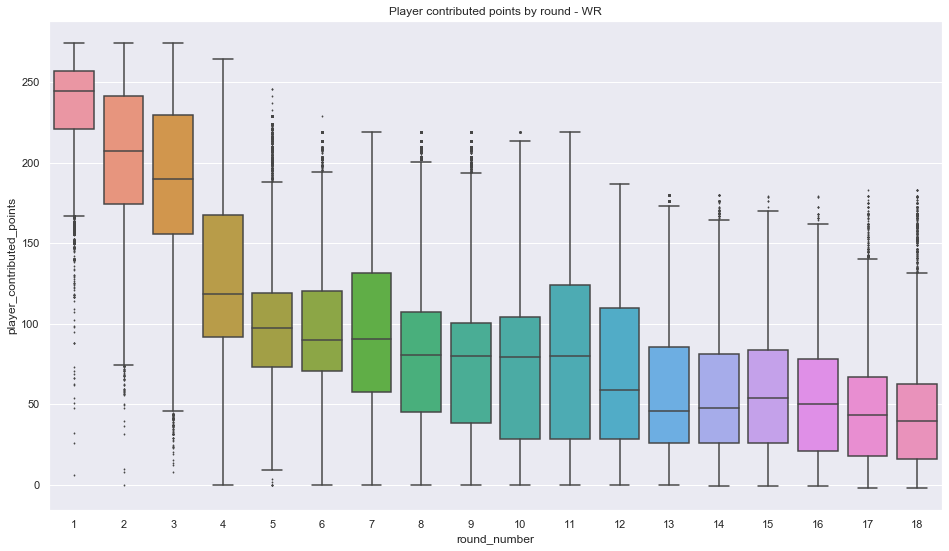

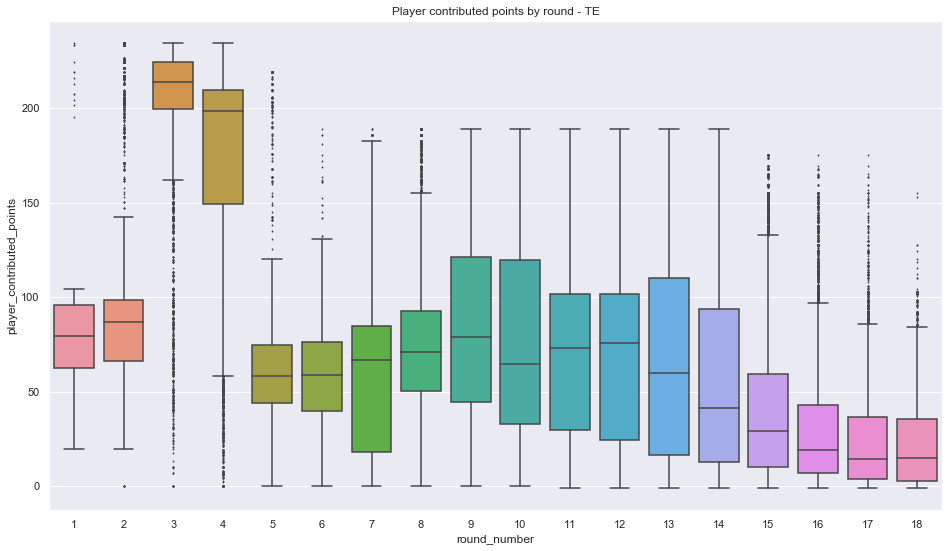

In [15]:
for position in POSITIONS:
    _data = df_base[df_base['position'] == position.upper()]
    
    sns.boxplot(
        data=_data,
        x='round_number',
        y='player_contributed_points',
        fliersize=1
    )
    
    plt.title('Player contributed points by round - {0}'.format(position.upper()))
    plt.show()

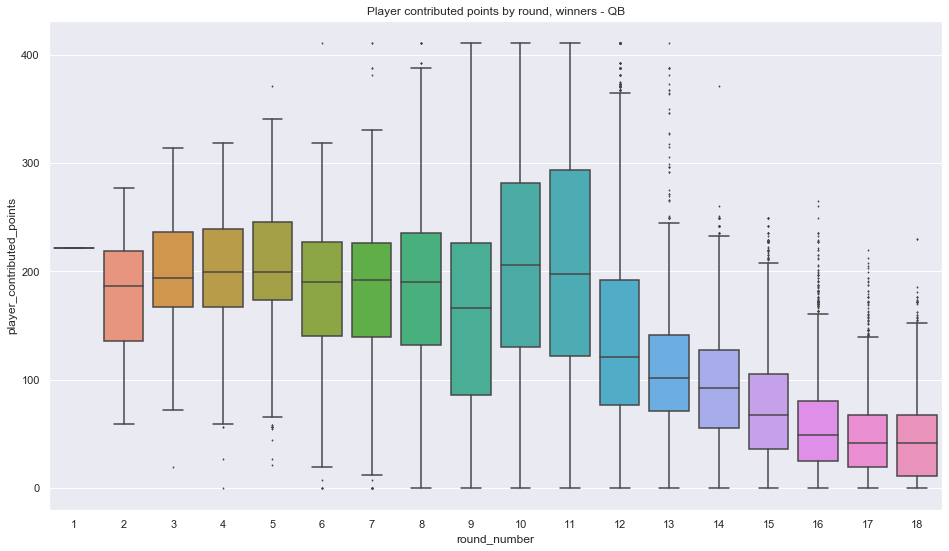

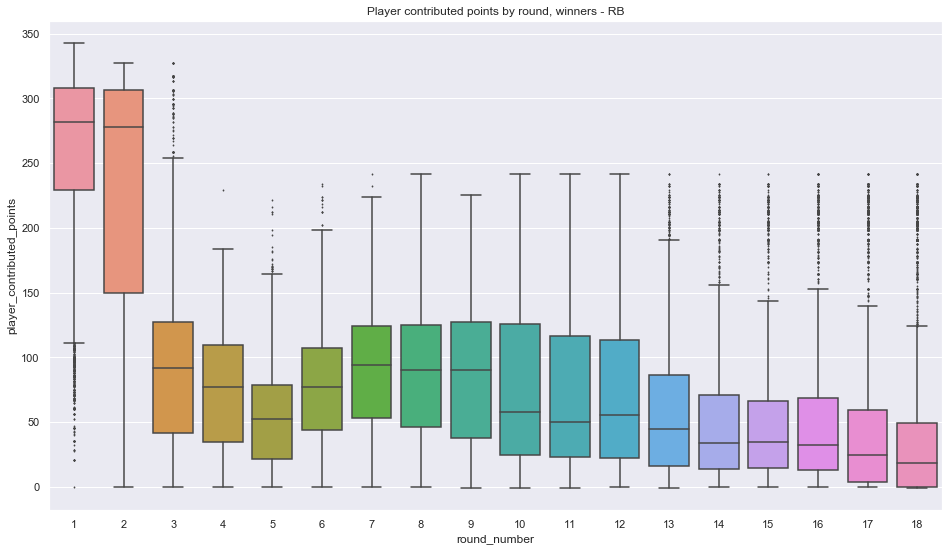

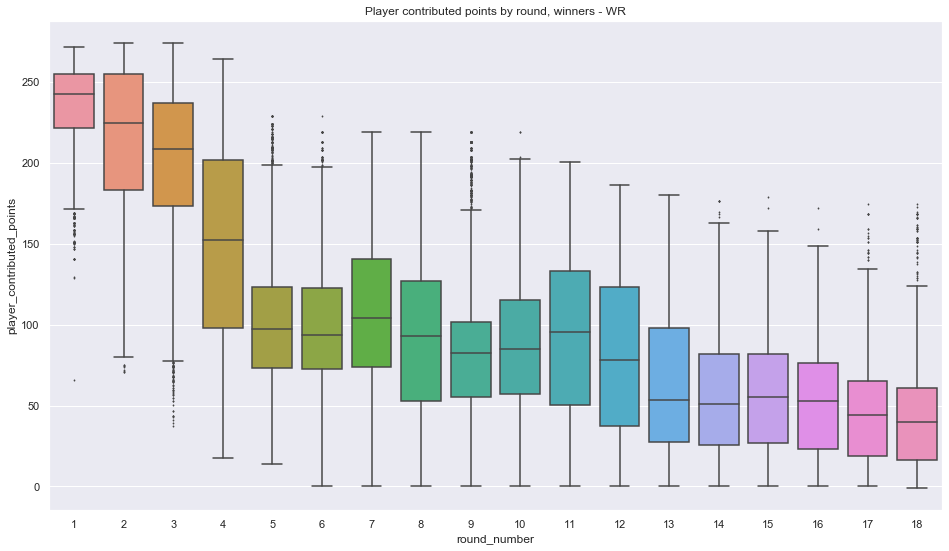

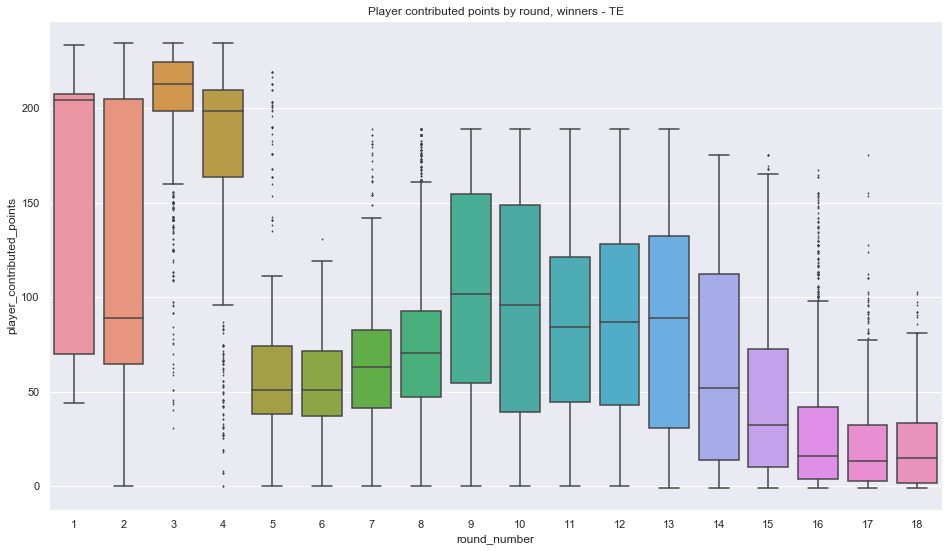

In [16]:
for position in POSITIONS:
    _data = df_base[
        (df_base['position'] == position.upper()) & 
        (df_base['win_flag'] == 1)
    ]
    
    sns.boxplot(
        data=_data,
        x='round_number',
        y='player_contributed_points',
        fliersize=1
    )
    
    plt.title('Player contributed points by round, winners - {0}'.format(position.upper()))
    plt.show()

## Modeling

In [17]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        sample=None,
        model=None,
        lam=None,
        n_splines=10,
        test_size=0.2
    ):
    
    # Fail if no model provided
    if model is None:
        return
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Sample data if requested
    if sample is not None:
        _df = _df.sample(frac=sample, replace=False)
        
    # Handle None inputs        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].values
    y = _df[label].values
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
                
    # Train the model
    model.gridsearch(
        X_train,
        y_train,
        return_scores=True,
        lam=lam
    )

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(num_terms))
    ax_idx = 0
        
    for i, term in enumerate(model.terms):
        if term.isintercept or term.istensor:
            continue
            
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

        if len(num_terms) > 1:
            ax = axs[ax_idx]
            ax_idx += 1
        else:
            ax = axs

        ax.plot(XX[:, term.feature], pdep)
        ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(term.feature)

    plt.show()
    
    # Tensor terms
    plt.rcParams['figure.figsize'] = (12, 8)
    
    for i, term in enumerate(model.terms):
        if not term.istensor:
            continue

        XX = model.generate_X_grid(term=i, meshgrid=True)
        Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

        ax = plt.axes(projection='3d')
        ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
        plt.show()

    # Test the model against the held over test set
    y_pred = model.predict(X_test)
    
    # Model metrics
    print("Explained Variance: {:3.3f}".format(explained_variance_score(y_test, y_pred)))
    print("Mean Absolute Error: {:3.3f}".format(mean_absolute_error(y_test, y_pred)))
    print("Mean Squared Error: {:3.3f}".format(mean_squared_error(y_test, y_pred)))
    print("R2 Score: {:3.3f}".format(r2_score(y_test, y_pred)))

100% (5 of 5) |##########################| Elapsed Time: 0:01:50 Time:  0:01:50
/Users/ad/Documents/projects/nfl-playdraft-2017/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.0005
Link Function:                     IdentityLink Log Likelihood:                             -28761653.9958
Number of Samples:                      3020261 AIC:                                         57523331.9924
                                                AICc:                                        57523331.9925
                                                GCV:                                             5452.7757
                                                Scale:                                           5452.7399
                                                Pseudo R-Squared:                                   0.2467
Feature Function                  Lam

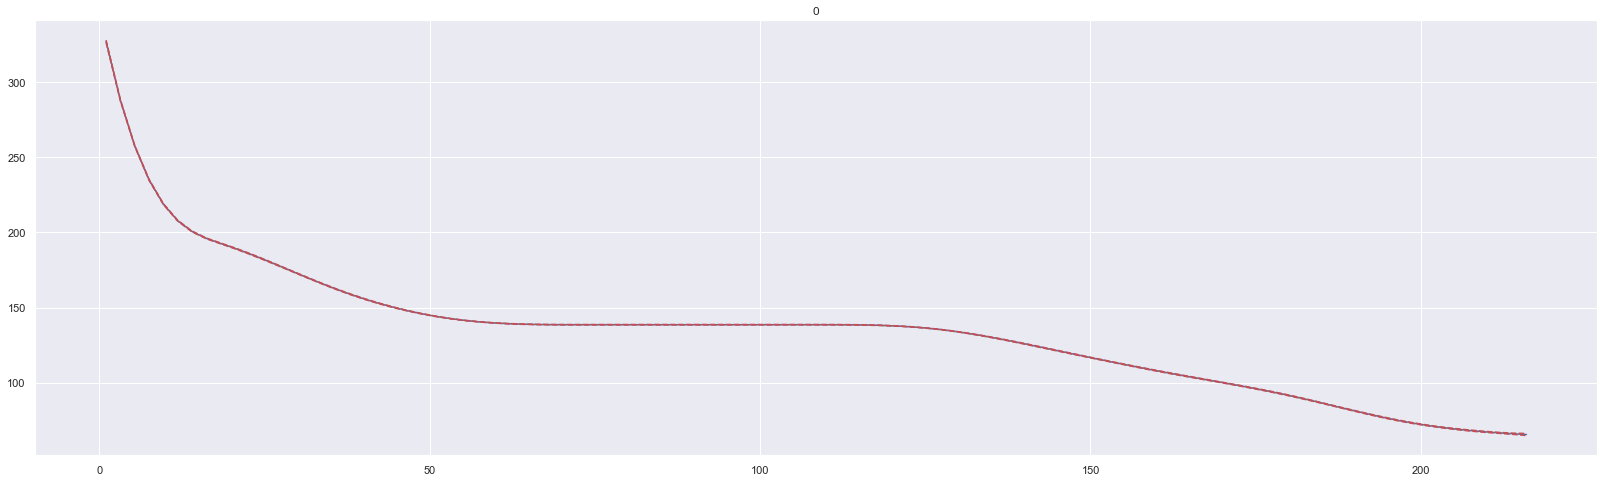

Explained Variance: 0.247
Mean Absolute Error: 57.523
Mean Squared Error: 5456.381
R2 Score: 0.247


In [18]:
gam_label_tb = 'player_total_points'
gam_features_tb = [
    'pick_number'
]
gam_constraints_tb = ['monotonic_dec']
gam_lam_tb = np.logspace(-10, 10, 5)
gam_model_tb = LinearGAM(
    s(0, n_splines=15, constraints='monotonic_dec'),
    fit_intercept=False
)

train_and_evaluate_gam(
    df=df_base,
    label=gam_label_tb,
    features=gam_features_tb,
    model=gam_model_tb,
    lam=gam_lam_tb,
    test_size=0.2
)

100% (5 of 5) |##########################| Elapsed Time: 0:01:36 Time:  0:01:36
/Users/ad/Documents/projects/nfl-playdraft-2017/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.0005
Link Function:                     IdentityLink Log Likelihood:                             -27702782.5333
Number of Samples:                      3020261 AIC:                                         55405587.0675
                                                AICc:                                        55405587.0676
                                                GCV:                                             3840.0916
                                                Scale:                                           3840.0687
                                                Pseudo R-Squared:                                   0.3692
Feature Function                  Lam

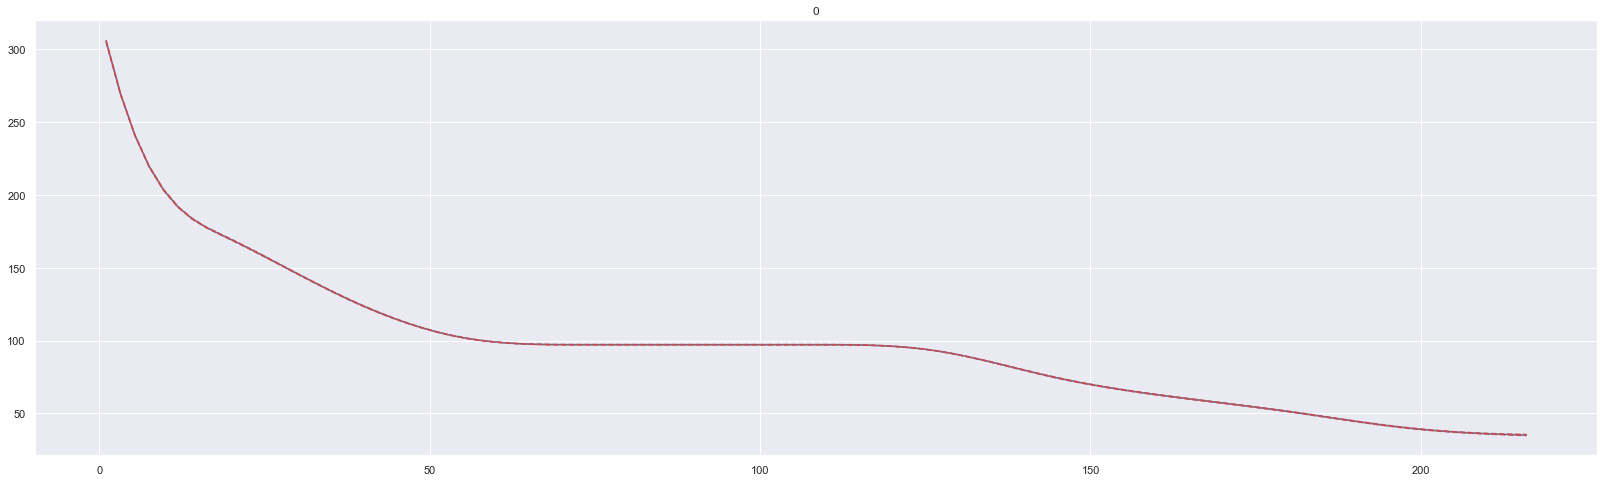

Explained Variance: 0.369
Mean Absolute Error: 47.853
Mean Squared Error: 3854.139
R2 Score: 0.369


In [19]:
gam_label_cb = 'player_contributed_points'
gam_features_cb = [
    'pick_number'
]
gam_constraints_cb = ['monotonic_dec']
gam_lam_cb = np.logspace(-10, 10, 5)
gam_model_cb = LinearGAM(
    s(0, n_splines=15, constraints='monotonic_dec'),
    fit_intercept=False
)

train_and_evaluate_gam(
    df=df_base,
    label=gam_label_cb,
    features=gam_features_cb,
    model=gam_model_cb,
    lam=gam_lam_cb,
    test_size=0.2
)

100% (5 of 5) |##########################| Elapsed Time: 0:13:44 Time:  0:13:44


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    306.0489
Link Function:                     IdentityLink Log Likelihood:                              -8615017.1394
Number of Samples:                       906078 AIC:                                         17230648.3766
                                                AICc:                                        17230648.5854
                                                GCV:                                             5375.4982
                                                Scale:                                             5372.23
                                                Pseudo R-Squared:                                   0.2577
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-playdraft-2017/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

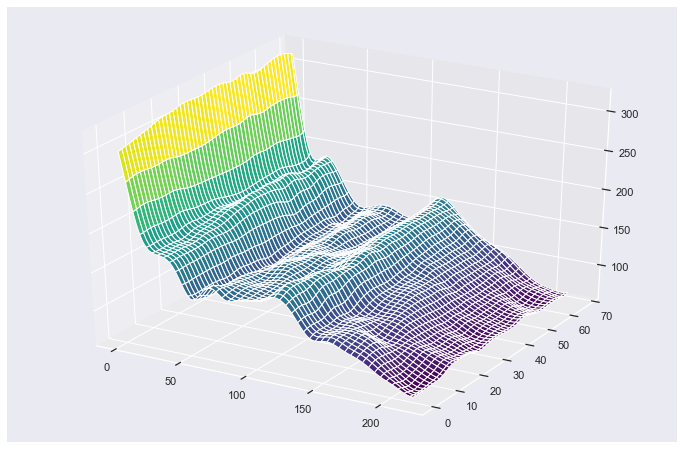

Explained Variance: 0.254
Mean Absolute Error: 57.044
Mean Squared Error: 5379.853
R2 Score: 0.254


In [22]:
gam_label_tt = 'player_total_points'
gam_features_tt = [
    'pick_number',
    'days_to_season'
]
gam_constraints_tt = ['monotonic_dec']
gam_lam_tt = np.logspace(-10, 10, 5)
gam_model_tt = LinearGAM(
    te(0, 1, n_splines=20),
    fit_intercept=False
)

train_and_evaluate_gam(
    df=df_base,
    label=gam_label_tt,
    features=gam_features_tt,
    model=gam_model_tt,
    sample=0.3,
    lam=gam_lam_tt,
    test_size=0.2
)

100% (5 of 5) |##########################| Elapsed Time: 0:13:14 Time:  0:13:14


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    305.9855
Link Function:                     IdentityLink Log Likelihood:                              -8301749.7031
Number of Samples:                       906078 AIC:                                         16604113.3771
                                                AICc:                                        16604113.5859
                                                GCV:                                             3804.0747
                                                Scale:                                           3801.7624
                                                Pseudo R-Squared:                                   0.3761
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-playdraft-2017/venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

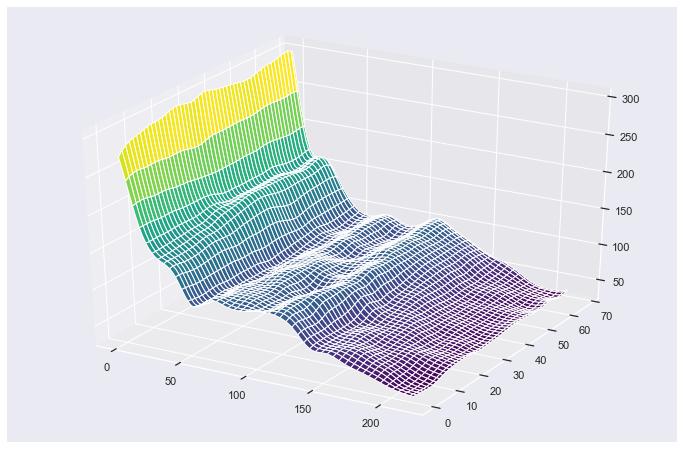

Explained Variance: 0.374
Mean Absolute Error: 47.603
Mean Squared Error: 3816.889
R2 Score: 0.374


In [23]:
gam_label_ct = 'player_contributed_points'
gam_features_ct = [
    'pick_number',
    'days_to_season'
]
gam_constraints_ct = ['monotonic_dec']
gam_lam_ct = np.logspace(-10, 10, 5)
gam_model_ct = LinearGAM(
    te(0, 1, n_splines=20),
    fit_intercept=False
)

train_and_evaluate_gam(
    df=df_base,
    label=gam_label_ct,
    features=gam_features_ct,
    model=gam_model_ct,
    sample=0.3,
    lam=gam_lam_ct,
    test_size=0.2
)